# 5. Evaluation (Model Değerlendirme)

## CRISP-DM'nin Beşinci Aşaması

Bu notebook'ta eğitilmiş modelleri detaylı şekilde değerlendireceğiz ve Business Understanding aşamasında belirlediğimiz hedeflerle karşılaştıracağız.

---

### İçindekiler
1. Veri ve Model Yükleme
2. En İyi Modelin Detaylı Değerlendirmesi
3. Confusion Matrix Analizi
4. ROC ve Precision-Recall Curve
5. Feature Importance Analizi
6. Tüm Modellerin Karşılaştırılması
7. Business Goals ile Karşılaştırma
8. Model Performans Özeti
9. Sonuç ve Öneriler

---

**Tarih:** 21 Ekim 2025  
**Proje:** Phishing Website Classification  
**Metodoloji:** CRISP-DM  
**Aşama:** Evaluation

---

### Business Understanding'den Hatırlatma

**Hedef Metrikler:**
- ✅ Accuracy ≥ 95%
- ✅ Precision ≥ 93%
- ✅ Recall ≥ 93%
- ✅ F1-Score ≥ 93%

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import sys
import joblib

warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Proje kök dizinini Python path'e ekle
project_root = Path.cwd().parent
sys.path.append(str(project_root))

from src import config
from src.evaluation import (
    full_model_evaluation,
    evaluate_all_models,
    compare_all_models_visual,
    evaluate_model,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_feature_importance,
    plot_precision_recall_curve,
    generate_classification_report_df
)
from src.model_training import load_model

print("✅ Kütüphaneler başarıyla yüklendi!")
print(f"📁 Proje Dizini: {config.BASE_DIR}")
print(f"📁 Model Dizini: {config.MODELS_DIR}")
print(f"📁 Grafik Dizini: {config.FIGURES_DIR}")

✅ Kütüphaneler başarıyla yüklendi!
📁 Proje Dizini: c:\Users\PC\Desktop\classification_project
📁 Model Dizini: c:\Users\PC\Desktop\classification_project\models
📁 Grafik Dizini: c:\Users\PC\Desktop\classification_project\reports\figures


## 1. Veri ve Model Yükleme

Test verilerini ve eğitilmiş modelleri yüklüyoruz.

**Yüklenecekler:**
- Test verisi (X_test, y_test)
- Özellik listesi
- En iyi model
- Tüm eğitilmiş modeller

In [21]:
print("="*80)
print("VERİ YÜKLEME")
print("="*80)

try:
    # Test verisini yükle
    test_data = pd.read_csv(config.TEST_DATA_FILE)
    print(f"\n✅ Test verisi yüklendi: {config.TEST_DATA_FILE.name}")
    print(f"   Boyut: {test_data.shape[0]:,} satır x {test_data.shape[1]} sütun")
    
    # Özellik listesini yükle
    with open(config.PROCESSED_DATA_DIR / "feature_names.txt", 'r', encoding='utf-8') as f:
        feature_names = [line.strip() for line in f.readlines()]
    
    print(f"\n✅ Özellik listesi yüklendi:")
    print(f"   • Özellik Sayısı: {len(feature_names)}")
    
    # X ve y'yi ayır
    X_test = test_data[feature_names]
    y_test = test_data[config.TARGET_NAME]
    
    print(f"\n✅ Test Seti Sınıf Dağılımı:")
    test_dist = y_test.value_counts().sort_index()
    for cls, count in test_dist.items():
        label = config.CLASS_LABELS[cls]
        percentage = (count / len(y_test)) * 100
        print(f"   • {label} ({cls:2}): {count:,} ({percentage:.2f}%)")
    
    print(f"\n✅ Veri yükleme tamamlandı!")
    
except Exception as e:
    print(f"❌ Hata: {e}")
    raise

VERİ YÜKLEME

✅ Test verisi yüklendi: test.csv
   Boyut: 1,170 satır x 28 sütun

✅ Özellik listesi yüklendi:
   • Özellik Sayısı: 27

✅ Test Seti Sınıf Dağılımı:
   • Phishing (-1): 604 (51.62%)
   • Legitimate ( 1): 566 (48.38%)

✅ Veri yükleme tamamlandı!


In [22]:
print("\n" + "="*80)
print("MODEL YÜKLEME")
print("="*80)

try:
    # Tüm modelleri yükle
    all_models = {}
    model_files = {
        'Random Forest': config.MODELS_DIR / 'random_forest.pkl',
        'Decision Tree': config.MODELS_DIR / 'decision_tree.pkl',
        'Gradient Boosting': config.MODELS_DIR / 'gradient_boosting.pkl',
        'Logistic Regression': config.MODELS_DIR / 'logistic_regression.pkl'
    }
    
    print(f"\n✅ Tüm modeller yükleniyor:")
    for model_name, model_path in model_files.items():
        if model_path.exists():
            all_models[model_name] = load_model(model_path, verbose=False)
            print(f"   • {model_name:<25} ✓")
        else:
            print(f"   • {model_name:<25} ✗ (bulunamadı)")
    
    print(f"\n✅ {len(all_models)} model başarıyla yüklendi!")
    
except Exception as e:
    print(f"❌ Hata: {e}")
    raise


MODEL YÜKLEME

✅ Tüm modeller yükleniyor:
   • Random Forest             ✓
   • Decision Tree             ✓
   • Gradient Boosting         ✓
   • Logistic Regression       ✓

✅ 4 model başarıyla yüklendi!


In [23]:
print("="*80)
print("TÜM MODELLERİN DETAYLI DEĞERLENDİRMESİ")
print("="*80)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report
)

# Her model için detaylı metrikleri hesapla
quick_results = []
all_confusion_matrices = {}
all_predictions = {}

for model_name, model in all_models.items():
    print(f"\n{'='*60}")
    print(f"⚙️  {model_name} DEĞERLENDİRİLİYOR")
    print(f"{'='*60}")
    
    # Tahminler
    y_pred = model.predict(X_test)
    all_predictions[model_name] = y_pred
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    all_confusion_matrices[model_name] = cm
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n📊 Confusion Matrix:")
    print(f"   • True Negative (TN):  {tn:4d} | True Positive (TP):  {tp:4d}")
    print(f"   • False Positive (FP): {fp:4d} | False Negative (FN): {fn:4d}")
    print(f"   • FP Rate: {(fp/(fp+tn)*100):5.2f}% | FN Rate: {(fn/(fn+tp)*100):5.2f}%")
    
    # Olasılık tahminleri (varsa)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    except:
        y_proba = None
        roc_auc = None
    
    # Metrikleri hesapla
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Sınıf bazlı metrikler
    precision_per_class = precision_score(y_test, y_pred, average=None)
    recall_per_class = recall_score(y_test, y_pred, average=None)
    f1_per_class = f1_score(y_test, y_pred, average=None)
    
    print(f"\n📈 Genel Metrikler:")
    print(f"   • Accuracy:  {accuracy:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall:    {recall:.4f}")
    print(f"   • F1-Score:  {f1:.4f}")
    if roc_auc:
        print(f"   • ROC-AUC:   {roc_auc:.4f}")
    
    print(f"\n📋 Sınıf Bazlı Metrikler:")
    for idx, cls in enumerate(sorted(config.CLASS_LABELS.keys())):
        label = config.CLASS_LABELS[cls]
        print(f"   {label} ({cls}):")
        print(f"      Precision: {precision_per_class[idx]:.4f} | Recall: {recall_per_class[idx]:.4f} | F1: {f1_per_class[idx]:.4f}")
    
    # Sonuçları kaydet
    metrics = {
        'Model': model_name,
        'Test_Accuracy': accuracy,
        'Test_Precision': precision,
        'Test_Recall': recall,
        'Test_F1': f1,
        'Test_ROC_AUC': roc_auc,
        'Training_Time': 0.0,
        'TP': int(tp),
        'TN': int(tn),
        'FP': int(fp),
        'FN': int(fn),
        'FP_Rate': fp/(fp+tn),
        'FN_Rate': fn/(fn+tp),
        'Phishing_Precision': precision_per_class[0],
        'Phishing_Recall': recall_per_class[0],
        'Phishing_F1': f1_per_class[0],
        'Legitimate_Precision': precision_per_class[1],
        'Legitimate_Recall': recall_per_class[1],
        'Legitimate_F1': f1_per_class[1]
    }
    
    quick_results.append(metrics)

# DataFrame oluştur
results_df = pd.DataFrame(quick_results)
results_df = results_df.sort_values('Test_F1', ascending=False)

print(f"\n" + "="*80)
print("GENEL SONUÇLAR (F1-Score'a göre sıralanmış)")
print("="*80)
print()

# Temel metrikleri göster
basic_metrics = ['Model', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_ROC_AUC']
display(results_df[basic_metrics].round(4))

print(f"\n📊 Confusion Matrix Özeti:")
cm_summary = results_df[['Model', 'TP', 'TN', 'FP', 'FN', 'FP_Rate', 'FN_Rate']].copy()
cm_summary['FP_Rate'] = cm_summary['FP_Rate'].apply(lambda x: f'{x*100:.2f}%')
cm_summary['FN_Rate'] = cm_summary['FN_Rate'].apply(lambda x: f'{x*100:.2f}%')
display(cm_summary)

print(f"\n📋 Sınıf Bazlı Performans Özeti:")
class_metrics = results_df[['Model', 'Phishing_F1', 'Legitimate_F1']].copy()
class_metrics.columns = ['Model', 'Phishing F1', 'Legitimate F1']
display(class_metrics.round(4))

# En iyi modeli belirle
best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['Test_F1']
best_accuracy = results_df.iloc[0]['Test_Accuracy']

print(f"\n🏆 EN İYİ MODEL: {best_model_name}")
print(f"   • F1-Score: {best_f1:.4f}")
print(f"   • Accuracy: {best_accuracy:.4f}")
print(f"   • Precision: {results_df.iloc[0]['Test_Precision']:.4f}")
print(f"   • Recall: {results_df.iloc[0]['Test_Recall']:.4f}")

# En iyi modeli seç
best_model = all_models[best_model_name]

TÜM MODELLERİN DETAYLI DEĞERLENDİRMESİ

⚙️  Random Forest DEĞERLENDİRİLİYOR

📊 Confusion Matrix:
   • True Negative (TN):   571 | True Positive (TP):   537
   • False Positive (FP):   33 | False Negative (FN):   29
   • FP Rate:  5.46% | FN Rate:  5.12%

📈 Genel Metrikler:
   • Accuracy:  0.9470
   • Precision: 0.9470
   • Recall:    0.9470
   • F1-Score:  0.9470
   • ROC-AUC:   0.9892

📋 Sınıf Bazlı Metrikler:
   Phishing (-1):
      Precision: 0.9517 | Recall: 0.9454 | F1: 0.9485
   Legitimate (1):
      Precision: 0.9421 | Recall: 0.9488 | F1: 0.9454

⚙️  Decision Tree DEĞERLENDİRİLİYOR

📊 Confusion Matrix:
   • True Negative (TN):   569 | True Positive (TP):   517
   • False Positive (FP):   35 | False Negative (FN):   49
   • FP Rate:  5.79% | FN Rate:  8.66%

📈 Genel Metrikler:
   • Accuracy:  0.9282
   • Precision: 0.9284
   • Recall:    0.9282
   • F1-Score:  0.9282
   • ROC-AUC:   0.9547

📋 Sınıf Bazlı Metrikler:
   Phishing (-1):
      Precision: 0.9207 | Recall: 0.9421 | F1:

,Model,Test_Accuracy,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC
2,Gradient Boosting,0.9538,0.9538,0.9538,0.9538,0.9925
0,Random Forest,0.9470,0.9470,0.9470,0.9470,0.9892
1,Decision Tree,0.9282,0.9284,0.9282,0.9282,0.9547
3,Logistic Regression,0.9111,0.9114,0.9111,0.9111,0.9734



📊 Confusion Matrix Özeti:


,Model,TP,TN,FP,FN,FP_Rate,FN_Rate
2,Gradient Boosting,538,578,26,28,4.30%,4.95%
0,Random Forest,537,571,33,29,5.46%,5.12%
1,Decision Tree,517,569,35,49,5.79%,8.66%
3,Logistic Regression,521,545,59,45,9.77%,7.95%



📋 Sınıf Bazlı Performans Özeti:


,Model,Phishing F1,Legitimate F1
2,Gradient Boosting,0.9554,0.9522
0,Random Forest,0.9485,0.9454
1,Decision Tree,0.9313,0.9249
3,Logistic Regression,0.9129,0.9092



🏆 EN İYİ MODEL: Gradient Boosting
   • F1-Score: 0.9538
   • Accuracy: 0.9538
   • Precision: 0.9538
   • Recall: 0.9538


GÖRSEL MODEL KARŞILAŞTIRMASI


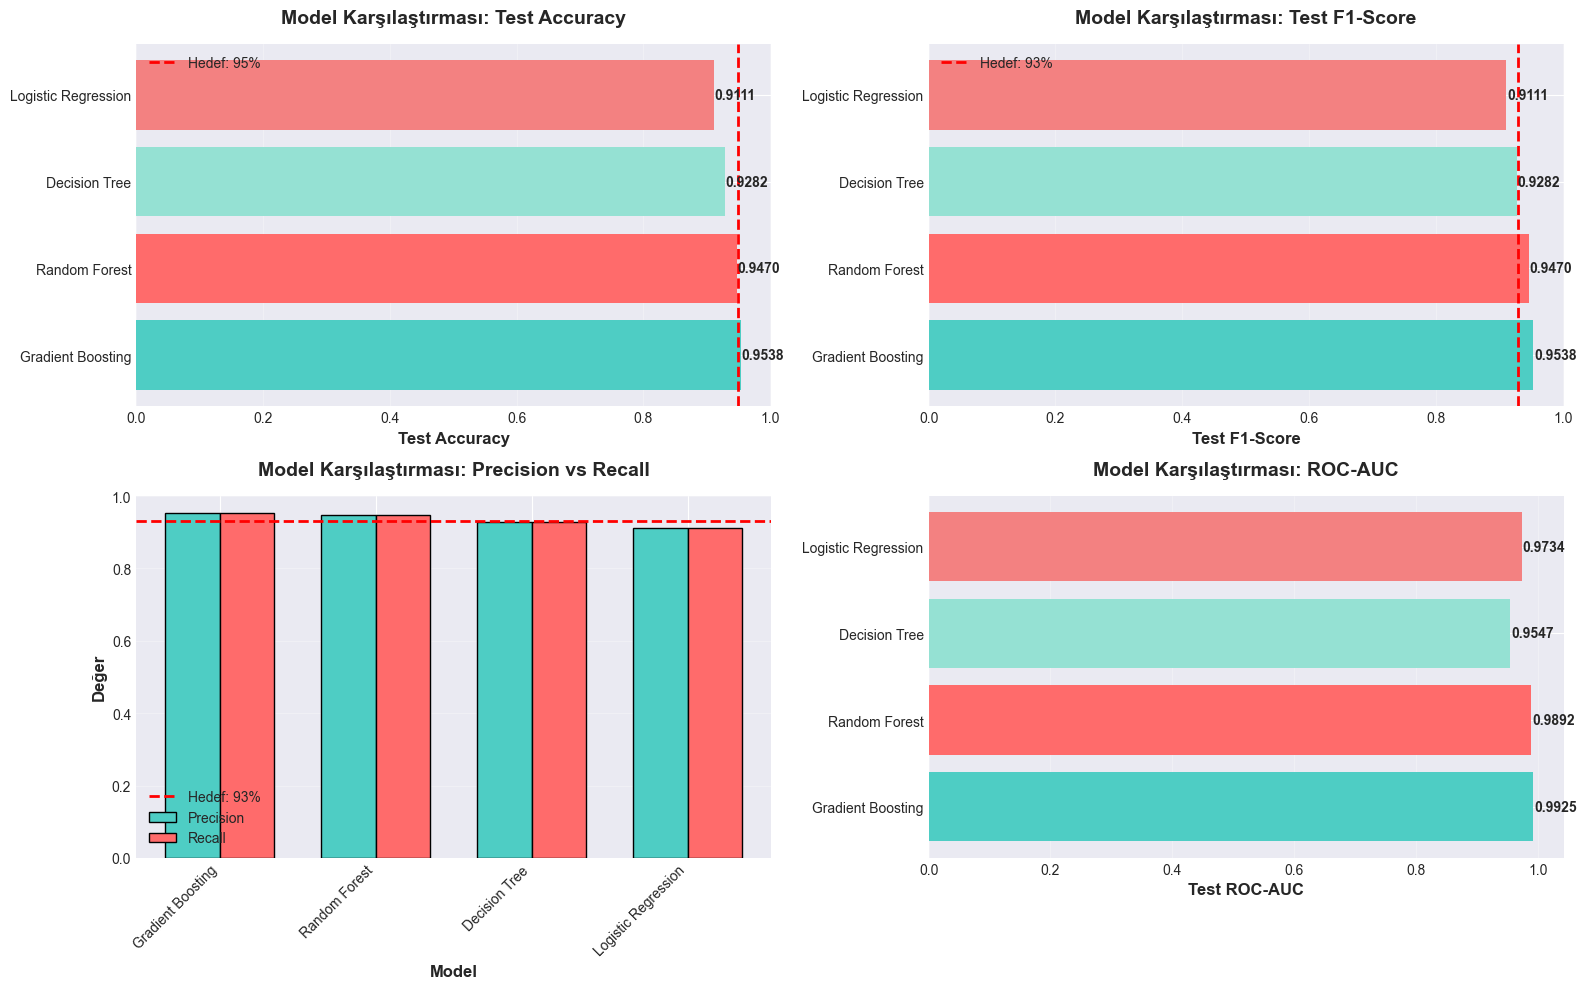


✅ Grafik kaydedildi: c:\Users\PC\Desktop\classification_project\reports\figures\model_comparison.png


In [24]:
print("="*80)
print("GÖRSEL MODEL KARŞILAŞTIRMASI")
print("="*80)

# Model karşılaştırma grafiği
compare_all_models_visual(
    comparison_df=results_df,
    figsize=(16, 10),
    save_path=config.FIGURES_DIR / 'model_comparison.png'
)

print(f"\n✅ Grafik kaydedildi: {config.FIGURES_DIR / 'model_comparison.png'}")

TÜM MODELLERİN ROC EĞRİLERİ
✅ Random Forest             ROC-AUC: 0.9892
✅ Decision Tree             ROC-AUC: 0.9547
✅ Gradient Boosting         ROC-AUC: 0.9925
✅ Logistic Regression       ROC-AUC: 0.9734


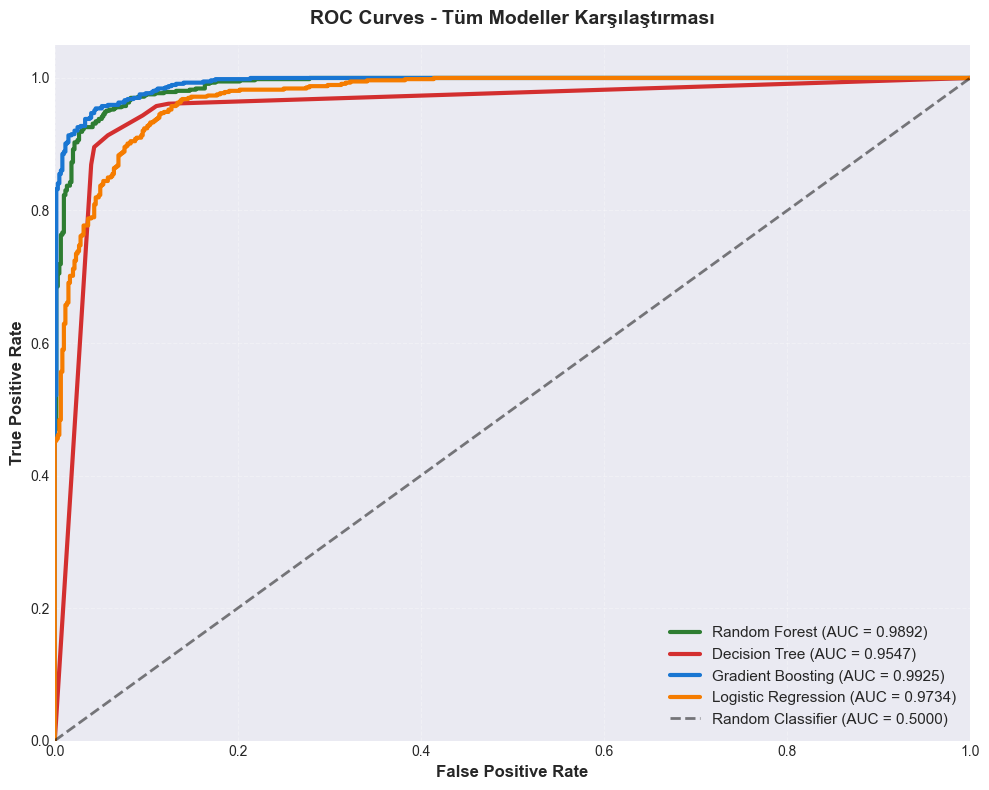


✅ Grafik kaydedildi: c:\Users\PC\Desktop\classification_project\reports\figures\all_models_roc_curves.png


In [25]:
print("="*80)
print("TÜM MODELLERİN ROC EĞRİLERİ")
print("="*80)

from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))

# Daha belirgin renkler
colors = {
    'Random Forest': '#2E7D32',      # Koyu yeşil
    'Decision Tree': '#D32F2F',      # Koyu kırmızı
    'Gradient Boosting': '#1976D2',  # Mavi
    'Logistic Regression': '#F57C00' # Turuncu
}

for model_name, model in all_models.items():
    try:
        # Olasılık tahminleri
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # ROC curve hesapla
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        # Çiz
        plt.plot(fpr, tpr, lw=3, 
                 label=f'{model_name} (AUC = {roc_auc:.4f})',
                 color=colors.get(model_name, '#000000'))
        
        print(f"✅ {model_name:<25} ROC-AUC: {roc_auc:.4f}")
        
    except Exception as e:
        print(f"⚠️  {model_name:<25} ROC hesaplanamadı: {e}")
        continue

# Random classifier (baseline)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5000)', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Tüm Modeller Karşılaştırması', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc="lower right", fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

# Kaydet
save_path = config.FIGURES_DIR / 'all_models_roc_curves.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Grafik kaydedildi: {save_path}")

## Her Modelin Detaylı ROC Eğrisi


HER MODELİN AYRI ROC EĞRİSİ
✅ Random Forest             ROC-AUC: 0.9892 | Optimal Threshold: 0.614
✅ Decision Tree             ROC-AUC: 0.9547 | Optimal Threshold: 0.667
✅ Gradient Boosting         ROC-AUC: 0.9925 | Optimal Threshold: 0.480
✅ Logistic Regression       ROC-AUC: 0.9734 | Optimal Threshold: 0.379


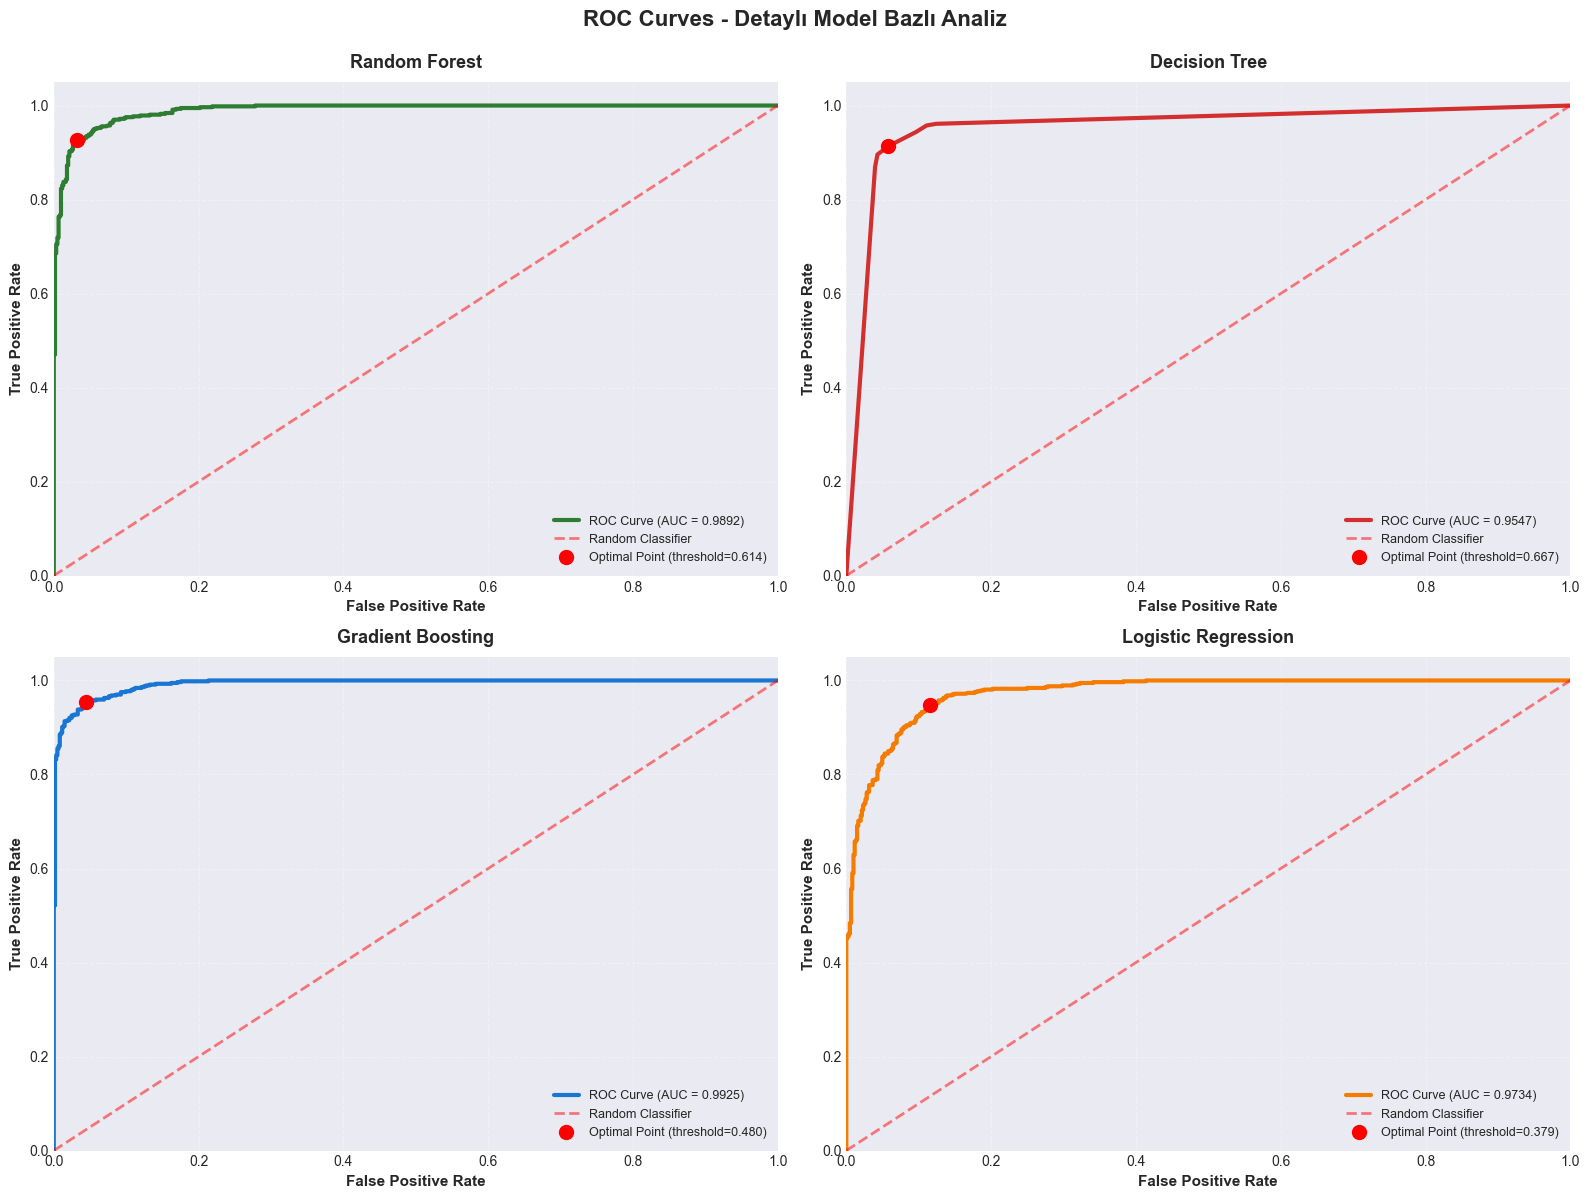


✅ Grafik kaydedildi: c:\Users\PC\Desktop\classification_project\reports\figures\individual_roc_curves.png


In [26]:
print("="*80)
print("HER MODELİN AYRI ROC EĞRİSİ")
print("="*80)

from sklearn.metrics import roc_curve, auc

# 2x2 subplot oluştur
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

colors_individual = {
    'Random Forest': '#2E7D32',
    'Decision Tree': '#D32F2F',
    'Gradient Boosting': '#1976D2',
    'Logistic Regression': '#F57C00'
}

for idx, (model_name, model) in enumerate(all_models.items()):
    ax = axes[idx]
    
    try:
        # Olasılık tahminleri
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # ROC curve hesapla
        fpr, tpr, thresholds = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        
        # ROC eğrisini çiz
        ax.plot(fpr, tpr, lw=3, 
                label=f'ROC Curve (AUC = {roc_auc:.4f})',
                color=colors_individual.get(model_name, '#000000'))
        
        # Random classifier
        ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', 
                label='Random Classifier', alpha=0.5)
        
        # Optimal threshold noktasını işaretle (Youden's J statistic)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        ax.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
                label=f'Optimal Point (threshold={optimal_threshold:.3f})')
        
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
        ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
        ax.set_title(f'{model_name}', fontsize=13, fontweight='bold', pad=10)
        ax.legend(loc="lower right", fontsize=9)
        ax.grid(alpha=0.3, linestyle='--')
        
        print(f"✅ {model_name:<25} ROC-AUC: {roc_auc:.4f} | Optimal Threshold: {optimal_threshold:.3f}")
        
    except Exception as e:
        ax.text(0.5, 0.5, f'ROC hesaplanamadı:\n{str(e)}', 
                ha='center', va='center', fontsize=10)
        ax.set_title(f'{model_name} - Hata', fontsize=13, fontweight='bold')
        print(f"⚠️  {model_name:<25} ROC hesaplanamadı: {e}")

plt.suptitle('ROC Curves - Detaylı Model Bazlı Analiz', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()

# Kaydet
save_path = config.FIGURES_DIR / 'individual_roc_curves.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Grafik kaydedildi: {save_path}")

In [27]:
print("="*80)
print(f"EN İYİ MODEL: {best_model_name.upper()} - DETAYLI DEĞERLENDİRME")
print("="*80)

# Tahminler
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print(f"\n✅ Tahminler tamamlandı!")
print(f"   • Test Seti Boyutu: {len(y_test):,}")
print(f"   • Tahmin Edilen Sınıflar: {np.unique(y_pred)}")

EN İYİ MODEL: GRADIENT BOOSTING - DETAYLI DEĞERLENDİRME

✅ Tahminler tamamlandı!
   • Test Seti Boyutu: 1,170
   • Tahmin Edilen Sınıflar: [-1  1]



CONFUSION MATRIX


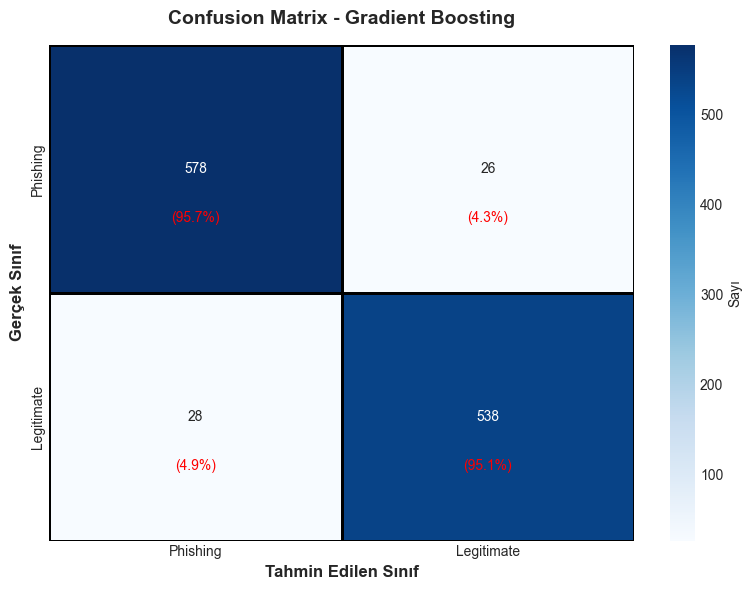


📊 Confusion Matrix Detayları:
   • True Negative (TN):  578 - Doğru tahmin edilen Legitimate
   • False Positive (FP): 26 - Yanlış Phishing diye etiketlenen Legitimate
   • False Negative (FN): 28 - Kaçırılan Phishing siteleri
   • True Positive (TP):  538 - Doğru tespit edilen Phishing

⚠️  Kritik Metrikler:
   • False Positive Rate: 4.30% (Legitimate sitelerin yanlış bloklanma oranı)
   • False Negative Rate: 4.95% (Phishing sitelerin kaçırılma oranı)


In [28]:
print("\n" + "="*80)
print("CONFUSION MATRIX")
print("="*80)

from sklearn.metrics import confusion_matrix

# Confusion matrix hesapla
cm = confusion_matrix(y_test, y_pred)

# Görselleştir
plot_confusion_matrix(
    cm=cm,
    class_labels=config.CLASS_LABELS,
    model_name=best_model_name,
    figsize=(8, 6),
    save_path=config.FIGURES_DIR / f'{best_model_name.lower().replace(" ", "_")}_confusion_matrix.png'
)

# Confusion matrix analizi
tn, fp, fn, tp = cm.ravel()

print(f"\n📊 Confusion Matrix Detayları:")
print(f"   • True Negative (TN):  {tn:,} - Doğru tahmin edilen Legitimate")
print(f"   • False Positive (FP): {fp:,} - Yanlış Phishing diye etiketlenen Legitimate")
print(f"   • False Negative (FN): {fn:,} - Kaçırılan Phishing siteleri")
print(f"   • True Positive (TP):  {tp:,} - Doğru tespit edilen Phishing")

print(f"\n⚠️  Kritik Metrikler:")
print(f"   • False Positive Rate: {(fp/(fp+tn)*100):.2f}% (Legitimate sitelerin yanlış bloklanma oranı)")
print(f"   • False Negative Rate: {(fn/(fn+tp)*100):.2f}% (Phishing sitelerin kaçırılma oranı)")

In [29]:
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)

from sklearn.metrics import classification_report

# Classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = generate_classification_report_df(report_dict, config.CLASS_LABELS)

print("\n📊 Sınıf Bazlı Metrikler:")
display(report_df.round(4))

# Sınıf bazlı analiz
print(f"\n📋 Sınıf Bazlı Analiz:")
for cls in sorted(config.CLASS_LABELS.keys()):
    label = config.CLASS_LABELS[cls]
    cls_str = str(cls)
    
    if cls_str in report_dict:
        precision = report_dict[cls_str]['precision']
        recall = report_dict[cls_str]['recall']
        f1 = report_dict[cls_str]['f1-score']
        support = report_dict[cls_str]['support']
        
        print(f"\n   {label} ({cls}):")
        print(f"      • Precision: {precision:.4f} - {label} dendiğinde ne kadar doğru?")
        print(f"      • Recall:    {recall:.4f} - Gerçek {label}'lerin ne kadarı bulundu?")
        print(f"      • F1-Score:  {f1:.4f} - Precision ve Recall'un dengesi")
        print(f"      • Support:   {support} örnek")


CLASSIFICATION REPORT

📊 Sınıf Bazlı Metrikler:


,Class,Precision,Recall,F1-Score,Support
0,Phishing,0.9538,0.9570,0.9554,604.0
1,Legitimate,0.9539,0.9505,0.9522,566.0
2,Macro Avg,0.9538,0.9537,0.9538,1170.0
3,Weighted Avg,0.9538,0.9538,0.9538,1170.0



📋 Sınıf Bazlı Analiz:

   Phishing (-1):
      • Precision: 0.9538 - Phishing dendiğinde ne kadar doğru?
      • Recall:    0.9570 - Gerçek Phishing'lerin ne kadarı bulundu?
      • F1-Score:  0.9554 - Precision ve Recall'un dengesi
      • Support:   604.0 örnek

   Legitimate (1):
      • Precision: 0.9539 - Legitimate dendiğinde ne kadar doğru?
      • Recall:    0.9505 - Gerçek Legitimate'lerin ne kadarı bulundu?
      • F1-Score:  0.9522 - Precision ve Recall'un dengesi
      • Support:   566.0 örnek



FEATURE IMPORTANCE


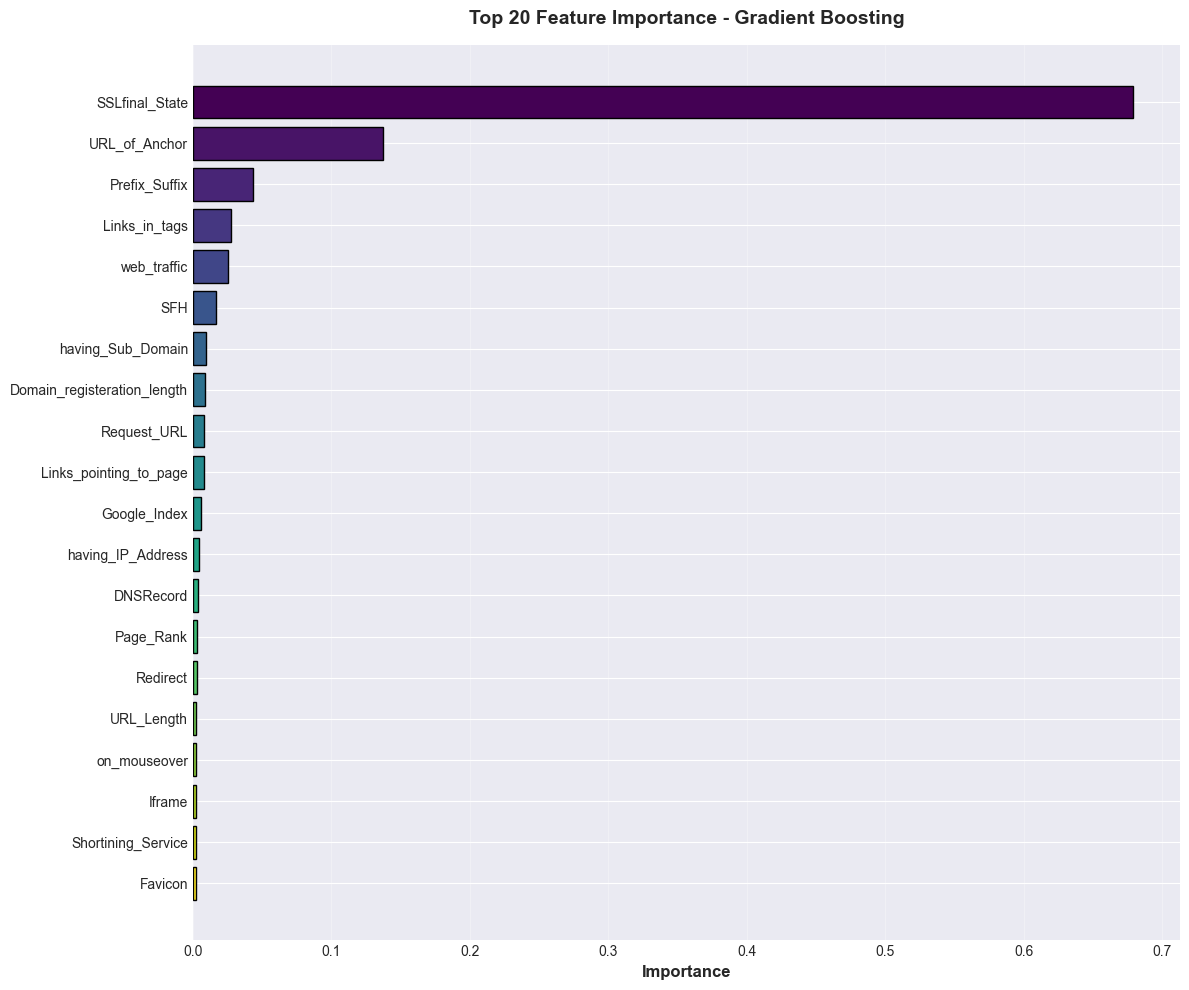


📊 En Önemli 10 Özellik:
    7. SSLfinal_State                      0.678767
   12. URL_of_Anchor                       0.137391
    5. Prefix_Suffix                       0.043420
   13. Links_in_tags                       0.027383
   23. web_traffic                         0.025124
   14. SFH                                 0.016976
    6. having_Sub_Domain                   0.009127
    8. Domain_registeration_length         0.008973
   11. Request_URL                         0.008224
   26. Links_pointing_to_page              0.007835

🏆 En Önemli Özellik: SSLfinal_State
   Importance: 0.678767

📈 İlk 10 özellik toplam önemin %96.32'ini oluşturuyor


In [30]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)

# Feature importance hesapla ve görselleştir
feature_imp_df = plot_feature_importance(
    model=best_model,
    feature_names=feature_names,
    model_name=best_model_name,
    top_n=20,
    figsize=(12, 10),
    save_path=config.FIGURES_DIR / f'{best_model_name.lower().replace(" ", "_")}_feature_importance.png'
)

if feature_imp_df is not None:
    print(f"\n📊 En Önemli 10 Özellik:")
    print("="*80)
    top_10 = feature_imp_df.head(10)
    for idx, row in top_10.iterrows():
        print(f"   {idx+1:2}. {row['Feature']:<35} {row['Importance']:.6f}")
    
    # En önemli özellik analizi
    most_important = feature_imp_df.iloc[0]
    print(f"\n🏆 En Önemli Özellik: {most_important['Feature']}")
    print(f"   Importance: {most_important['Importance']:.6f}")
    
    # Toplam önem yüzdesi
    top_10_importance = top_10['Importance'].sum()
    total_importance = feature_imp_df['Importance'].sum()
    print(f"\n📈 İlk 10 özellik toplam önemin %{(top_10_importance/total_importance*100):.2f}'ini oluşturuyor")


PRECISION-RECALL CURVE


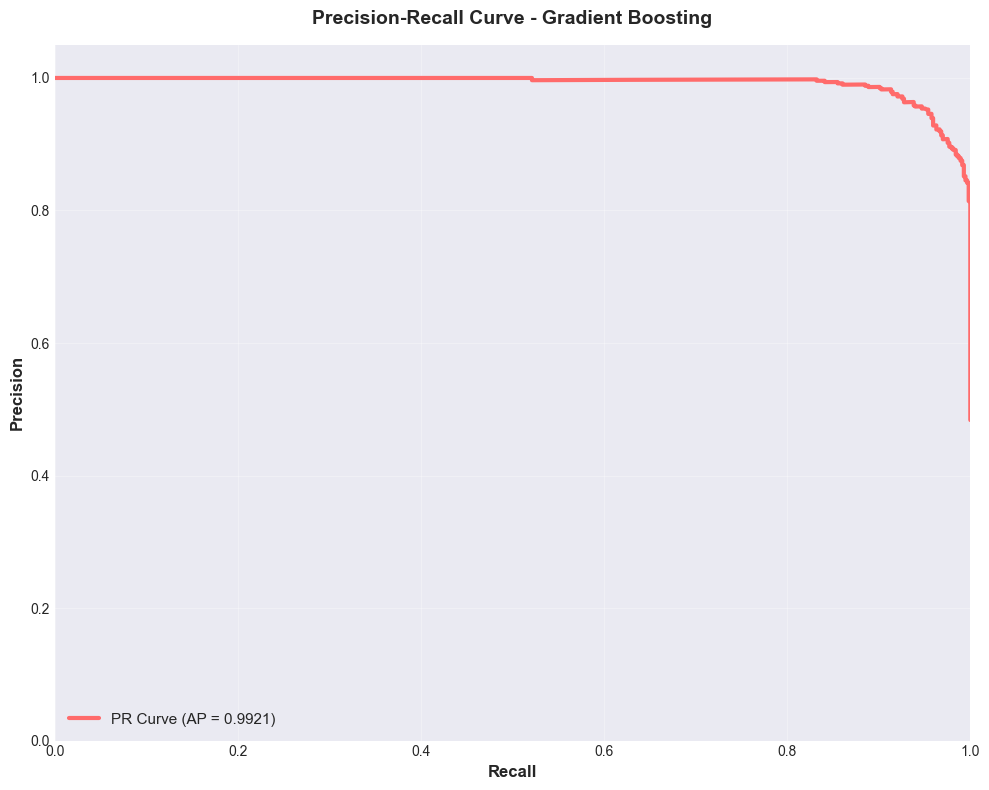


📊 Precision-Recall Analizi:
   • Average Precision Score: 0.9921
   • Bu değer 1'e ne kadar yakınsa model o kadar iyi

💡 Yorumlama:
   Precision-Recall eğrisi dengesiz sınıflarda ROC'tan daha bilgilendiricidir.
   Yüksek Precision: Az false positive (yanlış alarm)
   Yüksek Recall: Az false negative (kaçırılan phishing)


In [31]:
print("\n" + "="*80)
print("PRECISION-RECALL CURVE")
print("="*80)

from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision-Recall curve hesapla
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

# Görselleştir
plot_precision_recall_curve(
    precision=precision,
    recall=recall,
    avg_precision=avg_precision,
    model_name=best_model_name,
    figsize=(10, 8),
    save_path=config.FIGURES_DIR / f'{best_model_name.lower().replace(" ", "_")}_pr_curve.png'
)

print(f"\n📊 Precision-Recall Analizi:")
print(f"   • Average Precision Score: {avg_precision:.4f}")
print(f"   • Bu değer 1'e ne kadar yakınsa model o kadar iyi")
print(f"\n💡 Yorumlama:")
print(f"   Precision-Recall eğrisi dengesiz sınıflarda ROC'tan daha bilgilendiricidir.")
print(f"   Yüksek Precision: Az false positive (yanlış alarm)")
print(f"   Yüksek Recall: Az false negative (kaçırılan phishing)")

## Business Goals Karşılaştırması

Business Understanding aşamasında belirlenen hedeflerle karşılaştırılması:

**Belirlenen Hedefler:**
| Metrik | Hedef | Ulaşılan | Durum |
|--------|-------|----------|-------|
| **Accuracy** | ≥ 95% | - | - |
| **Precision** | ≥ 93% | - | - |
| **Recall** | ≥ 93% | - | - |
| **F1-Score** | ≥ 93% | - | - |

**Not:** Gerçek değerler bir sonraki hücrede hesaplanacak ve görselleştirilecek.

### 💡 İş Etkisi

- **Yüksek Precision öncelikli**: Kullanıcı deneyimi (meşru siteler bloklanmamalı)
- **Yüksek Recall öncelikli**: Güvenlik (phishing siteleri kaçırılmamalı)
- **Dengeli yaklaşım**: Her iki metrik de kritik, F1-Score dengeyi gösterir

Şimdi en iyi modelimizin bu hedeflere ulaşıp ulaşmadığını kontrol edelim.